In [1]:
# モジュールのインポート開始
import fsps
import sedpy
import lineid_plot
import numpy as np
import matplotlib.pyplot as plt

from dwarf_models import SDSS_EMLINES, simulate_dwarf_sed, test_single_model,\
    sigma_clipping_continuum, measure_ew_emission_line, design_model_grid,\
    generate_dwarf_population, measure_color_ew, plot_models_with_sdss, setup_fsps_spop


SDSS_EMLINES = {\
    'OII_3726': {'cen':3726.032, 'low':3717.0, 'upp':3737.0},\
    'OII_3729': {'cen':3728.815, 'low':3717.0, 'upp':3737.0},\
    'NeIII_3869': {'cen':3869.060, 'low':3859.0, 'upp':3879.0}, \
    'H_delta': {'cen':4101.734, 'low':4092.0, 'upp':4111.0},\
    'H_gamma': {'cen':4340.464, 'low':4330.0, 'upp':4350.0},\
    'OIII_4363': {'cen':4363.210, 'low':4350.0, 'upp':4378.0},\
    'H_beta': {'cen':4861.325, 'low':4851.0, 'upp':4871.0},\
    'OIII_4959': {'cen':4958.911, 'low':4949.0, 'upp':4969.0},\
    'OIII_5007': {'cen':5006.843, 'low':4997.0, 'upp':5017.0},\
    'HeI_5876': {'cen':5875.67, 'low':5866.0, 'upp':5886.0},\
    'OI_6300': {'cen':6300.304, 'low':6290.0, 'upp':6310.0},\
    'NII_6548': {'cen':6548.040, 'low':6533.0, 'upp':6553.0},\
    'H_alpha': {'cen':6562.800, 'low':6553.0, 'upp':6573.0},\
    'NII_6584': {'cen':6583.460, 'low':6573.0, 'upp':6593.0},\
    'SII_6717': {'cen':6716.440, 'low':6704.0, 'upp':6724.0},\
    'SII_6731': {'cen':6730.810, 'low':6724.0, 'upp':6744.0},\
    'ArIII7135': {'cen':7135.8, 'low':7130.0, 'upp':7140.0}
}


In [2]:
def select_var(var, set_size, vmin, vmax):

    # フィールド 展開 ！ 
    
    ranges = np.linspace(vmin, vmax, set_size)

    # メイン-パラメータ確認 ！
    tau_arr = np.full(set_size, 2.6) 
    const_arr =  np.full(set_size, 0.3) # const + fburst <= 1
    tage_arr =  np.full(set_size, 6.5)
    fburst_arr = np.full(set_size, 0.6)
    tburst_arr =  np.full(set_size, 5.0)
    logzsol_arr =  np.full(set_size, -0.8)
    gas_logz_arr =  np.full(set_size, -0.5)
    gas_logu_arr =  np.full(set_size, -3.2)
               
        
    if var == 'tau_arr':
        tar_arr = ranges
    elif var == 'const_arr':
        const_arr = ranges
    elif var == 'tage_arr':
        tage_arr = ranges
    elif var == 'fburst_arr':
        fburst_arr = ranges
    elif var == 'tburst_arr':
        tburst_arr = ranges
    elif var == 'logzsol_arr':
        logzsol_arr = ranges
    elif var == 'gas_logz_arr':
        gas_logz_arr = ranges
    elif var == 'gas_logu_arr':
        gas_logu_arr = ranges
    else:
        print('入力エラー！')
    
    return tau_arr, const_arr, tage_arr, fburst_arr, tburst_arr, logzsol_arr, gas_logz_arr, gas_logu_arr, set_size, ranges
    

In [3]:
def generate_sps_model(array_sets):

    
    tau_arr = array_sets[0]
    const_arr = array_sets[1]
    tage_arr = array_sets[2] 
    fburst_arr = array_sets[3]
    tburst_arr = array_sets[4] 
    logzsol_arr = array_sets[5]
    gas_logz_arr = array_sets[6]
    gas_logu_arr = array_sets[7]
    set_size = array_sets[8]
    ranges = array_sets[9]
            
    # 粉塵影響シンクロ確認 ！ 
    dust1_arr = np.full(set_size, 0.1)
    dust2_arr = np.full(set_size, 0.0)
    sf_trunc_arr = np.full(set_size, 0.0)
    
    # パラメータ-スペース展開 ！ 
    dwarf_sample_parameters = [
         {
             'dust1': dust1_arr[ii], 
             'dust2': dust2_arr[ii],
             'logzsol': logzsol_arr[ii], 
             'gas_logz': gas_logz_arr[ii], 
             'gas_logu': gas_logu_arr[ii],
             'const': const_arr[ii], 
             'tau': tau_arr[ii], 
             'tage': tage_arr[ii],
             'sf_trunc': sf_trunc_arr[ii], 
             'fburst': fburst_arr[ii], 
             'tburst': tburst_arr[ii]
         } for ii in np.arange(set_size)
    ]


    # バースト-タイミング確認 ！ 
    for ii, model in enumerate(dwarf_sample_parameters):
        if model['fburst'] + model['const'] >= 0.99:
            print(ii, model['fburst'], model['const'])


    print('# パラメータ展開完了！')
    
    # モデルを初期化開始
    spop_tau = setup_fsps_spop(
        zcontinuous=1, imf_type=2, sfh=1, dust_type=0, 
        dust_index=-1.3, dust1_index=-1.0)

    # SDSSフィルター獲る
    sdss_bands = fsps.find_filter('SDSS')

    print("# 初期化完了！")
    
    
    # モデルスペクトルと空間エネルギー分布生成
    dwarf_sample_gaussian = generate_dwarf_population(
        spop_tau, dwarf_sample_parameters, filters=sdss_bands, n_jobs=4)

    print("# モデルスペクトル 生成完了 !")

    # カラーと輝線同等幅測定
    # SDSS 輝線 SDSSは、輝線の中心波長と同等幅を測定するための波長
    # ウィンドウの定義済みディクショナリです.
    # - 結果をNumPy配列に保存できます

    dwarf_sample_table = measure_color_ew(
        dwarf_sample_gaussian, em_list=SDSS_EMLINES, output=None)

    print("# ジョブは終了!")
    
    return dwarf_sample_table, ranges


In [42]:
def plot_model(model, var = 'string'):
    
    dwarf_sample_table = model[0]
    var_arr = model[1]
    
    # カラーと輝線同等幅結果獲る
    sps_ur = dwarf_sample_table['ur_color']
    sps_ug = dwarf_sample_table['ug_color']
    sps_gr = dwarf_sample_table['gr_color']
    sps_gi = dwarf_sample_table['gi_color']
    sps_ha = np.log10(dwarf_sample_table['ew_halpha'])
    sps_hb = np.log10(dwarf_sample_table['ew_hbeta'])
    sps_oiii = np.log10(dwarf_sample_table['ew_oiii_5007'])
    
    # age plot
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(1, 1, 1)
    facecolor=plt.get_cmap('coolwarm')

    ax.plot(var_arr, sps_ur, marker='o', 
            c='#EF3E5B', 
            label=r'$u-r$')
    
    ax.plot(var_arr, sps_ug, marker='o', 
            c='#F26279', 
            label=r'$u-g$')
    
    ax.plot(var_arr, sps_gr, marker='o', 
            c='#4B256D', 
            label=r'$g-r$')
    
    ax.plot(var_arr, sps_gi, marker='o', 
            c='#6F5495', 
            label=r'$g-i$')
    
    ax.plot(var_arr, sps_ha, marker='o', c='#00B0B2',
            linestyle='dashed',label=r'$\log(\mathrm{EW(H}\alpha))$')
    
    ax.plot(var_arr, sps_hb, marker='o', c='#52CCCE', 
            linestyle='dashed',label=r'$\log(\mathrm{EW(H}\beta))$')
    
    ax.plot(var_arr, sps_oiii, marker='o', c='#95D47A',
            linestyle='dashed',label=r'$\log(\mathrm{EW([OIII])})$')
    
    ax.grid()
    plt.xlabel(xlabel=r'$\texttt{tau}\; [Gyr]$',fontsize=18)
    plt.ylabel(ylabel=r'$[\mathrm{mag}]\ \mathrm{ or }\ [\AA]$',fontsize=18)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5,1.3),
          ncol=3, fancybox=True, shadow=True)


In [39]:
parameters = select_var('tau_arr', 20, 1.0, 8.0)
model = generate_sps_model(parameters)


# パラメータ展開完了！
# 初期化完了！
# Will use multi-processing with 4 cores!
# モデルスペクトル 生成完了 !
# ジョブは終了!


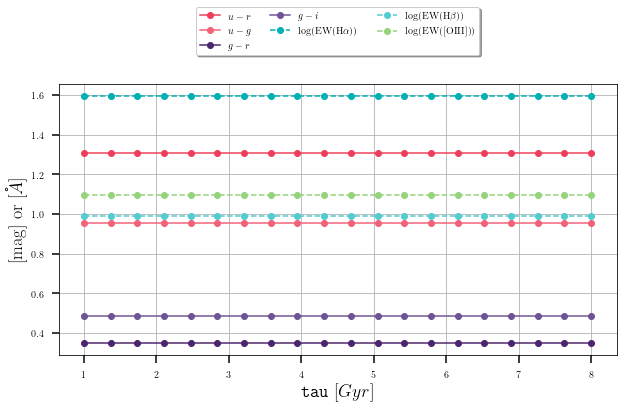

In [43]:
plot_model(model)